<a href="https://colab.research.google.com/github/ashwinvaswani/whatif/blob/master/Code/Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
  !pip install numpy==1.16.1

In [0]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt


import keras
from keras.models import Model, Sequential
from keras.layers import Dense, GlobalAveragePooling2D, Input, Embedding, Bidirectional, LSTM, Flatten, concatenate, Dropout, Conv1D, MaxPool1D, BatchNormalization, LeakyReLU, GRU, UpSampling1D, BatchNormalization
from keras import optimizers
from keras.callbacks import LearningRateScheduler, ModelCheckpoint
from keras import  regularizers

from keras.losses import mean_squared_error

import tensorflow as tf


Using TensorFlow backend.


# Loading dataset

In [0]:
matches_X = np.load("matches_X_final.npy")
players_X = np.load("players_X_final.npy")

In [0]:
print(matches_X.shape)
print(players_X.shape)

(157, 2, 23)
(157, 36, 10)


In [0]:
matches_X_new = np.reshape(matches_X, (matches_X.shape[0], matches_X.shape[1]*matches_X.shape[2]))
players_X_new = np.reshape(players_X, (players_X.shape[0], players_X.shape[1]*players_X.shape[2]))

In [0]:
print(matches_X_new.shape)
print(players_X_new.shape)


(157, 46)
(157, 360)


In [0]:
matches_X_train, matches_X_val, players_X_train, players_X_val = train_test_split(matches_X_new, players_X_new, shuffle=True, test_size=0.1)

In [0]:
print(matches_X_train.shape)
print(players_X_train.shape)

(141, 46)
(141, 360)


## Add noise to input

In [0]:
matches_train_mean = np.mean(matches_X_train)
matches_val_mean = np.mean(matches_X_val)
players_train_mean = np.mean(players_X_train)
players_val_mean = np.mean(players_X_val)

matches_train_std = np.std(matches_X_train,ddof=1)
matches_val_std = np.std(matches_X_val,ddof=1)
players_train_std = np.std(players_X_train,ddof=1)
players_val_std = np.std(players_X_val,ddof=1)



matches_X_train_noise = matches_X_train + np.random.normal(matches_train_mean,matches_train_std,matches_X_train.shape)
matches_X_val_noise = matches_X_val + np.random.normal(matches_val_mean,matches_val_std,matches_X_val.shape)
players_X_train_noise = players_X_train + np.random.normal(players_train_mean,players_train_std,players_X_train.shape)
players_X_val_noise = players_X_val + np.random.normal(players_val_mean,players_val_std,players_X_val.shape)

# Original Model

In [0]:
input_1 = Input(shape=(124, 1))
input_2 = Input(shape=(360, 1))

match = Conv1D(216, 3, activation='relu')(input_1)
match = Dropout(0.5)(match)
match = Flatten()(match)
match = Dense(216, activation='relu', kernel_initializer='normal')(match)
match = Dropout(0.5)(match)
match = Dense(128, activation='relu')(match)
match = Dropout(0.5)(match)

player = Conv1D(216, 3, activation='relu')(input_2)
player = Dropout(0.5)(player)
player = Flatten()(player)
player = Dense(216, activation='relu', kernel_initializer='normal')(player)
player = Dropout(0.5)(player)
player = Dense(128, activation='relu')(player)
player = Dropout(0.5)(player)

concat = concatenate([match, player])
concat = Dense(128, activation='relu')(concat)
concat = Dropout(0.5)(concat)

out = Dense(297, activation='relu')(concat)

model = Model(inputs=[input_1, input_2], outputs=[out])
model.compile(optimizer='adam', loss='mse', metrics=[tf.keras.metrics.RootMeanSquaredError()])

In [0]:
model.summary()

In [0]:
history = model.fit(x=[matches_X_new_1, players_X_new_1], y=Y, validation_split=0.1, batch_size=10, epochs=100)
# history = model.fit(x=[matches_X_train, players_X_train],y=Y_train,  batch_size= 10,epochs=20)

# Autoencoder Model
Not being used

In [0]:
input_m = Input(shape=(124,1))
x = Conv1D(216, 3, activation='relu', padding='same')(input_m)
x = Dropout(0.5)(x)
x = MaxPool1D(2, padding='same')(x)
x = Conv1D(128, 3, activation='relu', padding='same')(x)
x = Dropout(0.5)(x)
x = MaxPool1D(2, padding='same')(x)
x = Conv1D(64, 3, activation='relu', padding='same')(x)
encoded = MaxPool1D(2, padding='same')(x)



x = Conv1D(64, 3, activation='relu', padding='same')(encoded)
x = UpSampling1D(2)(x)
x = Conv1D(128, 2, activation='relu')(x)
x = Dropout(0.5)(x)
x = UpSampling1D(2)(x)
x = Conv1D(216, 3, activation='relu', padding='same')(x)
x = Dropout(0.5)(x)
x = UpSampling1D(2)(x)
decoded = Conv1D(1, 3, activation='relu',padding='same')(x)

autoencoder_matches = Model(input_m, decoded)
autoencoder_matches.compile(optimizer='adam', loss='mse',metrics=[tf.keras.metrics.RootMeanSquaredError()])

In [0]:
autoencoder_matches.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 124, 1)            0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 124, 216)          864       
_________________________________________________________________
dropout_1 (Dropout)          (None, 124, 216)          0         
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 62, 216)           0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 62, 128)           83072     
_________________________________________________________________
dropout_2 (Dropout)          (None, 62, 128)           0         
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 31, 128)           0   

In [0]:
input_m = Input(shape=(360,1))
x = Conv1D(216, 3, activation='relu', padding='same')(input_m)
x = Dropout(0.5)(x)
x = MaxPool1D(2, padding='same')(x)
x = Conv1D(128, 3, activation='relu', padding='same')(x)
x = Dropout(0.5)(x)
x = MaxPool1D(2, padding='same')(x)
x = Conv1D(64, 3, activation='relu', padding='same')(x)
encoded = MaxPool1D(2, padding='same')(x)



x = Conv1D(64, 3, activation='relu', padding='same')(encoded)
x = UpSampling1D(2)(x)
x = Conv1D(128, 3, activation='relu', padding='same')(x)
x = Dropout(0.5)(x)
x = UpSampling1D(2)(x)
x = Conv1D(216, 3, activation='relu', padding='same')(x)
x = Dropout(0.5)(x)
x = UpSampling1D(2)(x)
decoded = Conv1D(1, 3, activation='relu', padding='same')(x)

autoencoder_player = Model(input_m, decoded)
autoencoder_player.compile(optimizer='adam', loss='mse',metrics=[tf.keras.metrics.RootMeanSquaredError()])

In [0]:
autoencoder_player.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 360, 1)            0         
_________________________________________________________________
conv1d_8 (Conv1D)            (None, 360, 216)          864       
_________________________________________________________________
dropout_5 (Dropout)          (None, 360, 216)          0         
_________________________________________________________________
max_pooling1d_4 (MaxPooling1 (None, 180, 216)          0         
_________________________________________________________________
conv1d_9 (Conv1D)            (None, 180, 128)          83072     
_________________________________________________________________
dropout_6 (Dropout)          (None, 180, 128)          0         
_________________________________________________________________
max_pooling1d_5 (MaxPooling1 (None, 90, 128)           0   

In [0]:
history = autoencoder_matches.fit(x=matches_X_train, y=matches_X_train, validation_data=(matches_X_val,matches_X_val), batch_size=10, epochs=100)

Train on 141 samples, validate on 16 samples
Epoch 1/100
141/141 [==============================] - 1s 10ms/step - loss: 0.0417 - root_mean_squared_error: 0.2157 - val_loss: 0.0482 - val_root_mean_squared_error: 0.2057
Epoch 2/100
141/141 [==============================] - 1s 4ms/step - loss: 0.0290 - root_mean_squared_error: 0.1962 - val_loss: 0.0435 - val_root_mean_squared_error: 0.1908
Epoch 3/100
141/141 [==============================] - 1s 4ms/step - loss: 0.0267 - root_mean_squared_error: 0.1860 - val_loss: 0.0414 - val_root_mean_squared_error: 0.1835
Epoch 4/100
141/141 [==============================] - 1s 4ms/step - loss: 0.0251 - root_mean_squared_error: 0.1803 - val_loss: 0.0372 - val_root_mean_squared_error: 0.1784
Epoch 5/100
141/141 [==============================] - 1s 4ms/step - loss: 0.0227 - root_mean_squared_error: 0.1758 - val_loss: 0.0337 - val_root_mean_squared_error: 0.1739
Epoch 6/100
141/141 [==============================] - 1s 4ms/step - loss: 0.0199 - root_

In [0]:
history_players = autoencoder_player.fit(x=players_X_train, y=players_X_train, validation_data=(players_X_val,players_X_val), batch_size=10, epochs=100)

Train on 141 samples, validate on 16 samples
Epoch 1/100
141/141 [==============================] - 2s 15ms/step - loss: 0.0716 - root_mean_squared_error: 0.2728 - val_loss: 0.0739 - val_root_mean_squared_error: 0.2680
Epoch 2/100
141/141 [==============================] - 1s 10ms/step - loss: 0.0674 - root_mean_squared_error: 0.2654 - val_loss: 0.0693 - val_root_mean_squared_error: 0.2641
Epoch 3/100
141/141 [==============================] - 1s 10ms/step - loss: 0.0660 - root_mean_squared_error: 0.2629 - val_loss: 0.0696 - val_root_mean_squared_error: 0.2619
Epoch 4/100
141/141 [==============================] - 1s 10ms/step - loss: 0.0623 - root_mean_squared_error: 0.2605 - val_loss: 0.0564 - val_root_mean_squared_error: 0.2587
Epoch 5/100
141/141 [==============================] - 1s 10ms/step - loss: 0.0464 - root_mean_squared_error: 0.2550 - val_loss: 0.0335 - val_root_mean_squared_error: 0.2503
Epoch 6/100
141/141 [==============================] - 1s 10ms/step - loss: 0.0297 - 

In [0]:
autoencoder_matches.save("autoencoder_matches.h5")
autoencoder_player.save("autoencoder_player.h5")

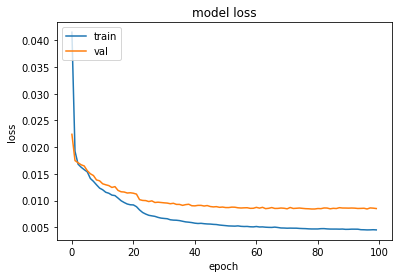

In [0]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [0]:
pred = model.predict(x=[matches_X_val, players_X_val])

# Deep Autoencoder
Current model

In [0]:
import keras.backend as K
def f1_loss(y_true, y_pred):
    
    tp = K.sum(K.cast(y_true*y_pred, 'float'), axis=0)
    tn = K.sum(K.cast((1-y_true)*(1-y_pred), 'float'), axis=0)
    fp = K.sum(K.cast((1-y_true)*y_pred, 'float'), axis=0)
    fn = K.sum(K.cast(y_true*(1-y_pred), 'float'), axis=0)

    p = tp / (tp + fp + K.epsilon())
    r = tp / (tp + fn + K.epsilon())

    f1 = 2*p*r / (p+r+K.epsilon())
    f1 = tf.where(tf.math.is_nan(f1), tf.zeros_like(f1), f1)
    return 1 - K.mean(f1)

In [0]:
input_m = Input(shape=(46,))
encoded = Dense(128, activation='relu')(input_m)
encoded = Dropout(0.5)(encoded)
encoded = Dense(64, activation='relu')(encoded)
encoded = Dense(32, activation='relu')(encoded)

decoded = Dense(64, activation='relu')(encoded)
decoded = Dropout(0.5)(decoded)
decoded = Dense(128, activation='relu')(decoded)
decoded = Dense(46, activation='relu')(decoded)

autoencoder_matches = Model(input_m, decoded)
autoencoder_matches.compile(optimizer='adam', loss=f1_loss,
                            metrics=[tf.keras.metrics.Precision(),tf.keras.metrics.Recall()])
autoencoder_matches.summary()

Model: "model_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         (None, 46)                0         
_________________________________________________________________
dense_41 (Dense)             (None, 128)               6016      
_________________________________________________________________
dropout_13 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_42 (Dense)             (None, 64)                8256      
_________________________________________________________________
dense_43 (Dense)             (None, 32)                2080      
_________________________________________________________________
dense_44 (Dense)             (None, 64)                2112      
_________________________________________________________________
dropout_14 (Dropout)         (None, 64)                0   

In [0]:
input_m = Input(shape=(360,))
encoded = Dense(128, activation='relu')(input_m)
encoded = Dropout(0.5)(encoded)
encoded = Dense(64, activation='relu')(encoded)
#encoded = Dropout(0.5)(encoded)
encoded = Dense(32, activation='relu')(encoded)
encoded = Dense(16, activation='relu')(encoded)

decoded = Dense(32, activation='relu')(encoded)
#decoded = Dropout(0.5)(decoded)
decoded = Dense(64, activation='relu')(decoded)
decoded = Dense(128, activation='relu')(decoded)
decoded = Dropout(0.5)(decoded)
decoded = Dense(360, activation='relu')(decoded)

autoencoder_players = Model(input_m, decoded)
autoencoder_players.compile(optimizer='adam', loss=f1_loss,
                            metrics=[tf.keras.metrics.Precision(),tf.keras.metrics.Recall()])
autoencoder_players.summary()

Model: "model_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         (None, 360)               0         
_________________________________________________________________
dense_47 (Dense)             (None, 128)               46208     
_________________________________________________________________
dropout_15 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_48 (Dense)             (None, 64)                8256      
_________________________________________________________________
dense_49 (Dense)             (None, 32)                2080      
_________________________________________________________________
dense_50 (Dense)             (None, 16)                528       
_________________________________________________________________
dense_51 (Dense)             (None, 32)                544 

In [0]:
history = autoencoder_matches.fit(x=matches_X_train, y=matches_X_train, validation_data=(matches_X_val,matches_X_val), batch_size=5, epochs=100)

Train on 141 samples, validate on 16 samples
Epoch 1/100
141/141 [==============================] - 0s 3ms/step - loss: 0.6971 - precision_4: 0.8181 - recall_4: 0.1747 - val_loss: 0.4695 - val_precision_4: 0.9441 - val_recall_4: 0.4519
Epoch 2/100
141/141 [==============================] - 0s 579us/step - loss: 0.4109 - precision_4: 0.9404 - recall_4: 0.5944 - val_loss: 0.3727 - val_precision_4: 0.9407 - val_recall_4: 0.6880
Epoch 3/100
141/141 [==============================] - 0s 458us/step - loss: 0.3492 - precision_4: 0.9402 - recall_4: 0.7440 - val_loss: 0.3376 - val_precision_4: 0.9412 - val_recall_4: 0.7878
Epoch 4/100
141/141 [==============================] - 0s 477us/step - loss: 0.3376 - precision_4: 0.9414 - recall_4: 0.8176 - val_loss: 0.3340 - val_precision_4: 0.9417 - val_recall_4: 0.8412
Epoch 5/100
141/141 [==============================] - 0s 545us/step - loss: 0.3368 - precision_4: 0.9418 - recall_4: 0.8586 - val_loss: 0.3319 - val_precision_4: 0.9419 - val_recall_4:

In [0]:
history_players = autoencoder_players.fit(x=players_X_train, y=players_X_train, validation_data=(players_X_val,players_X_val), batch_size=5, epochs=100)

Train on 141 samples, validate on 16 samples
Epoch 1/100
141/141 [==============================] - 0s 3ms/step - loss: 0.8883 - precision_5: 0.5160 - recall_5: 0.1106 - val_loss: 0.7733 - val_precision_5: 0.5571 - val_recall_5: 0.3699
Epoch 2/100
141/141 [==============================] - 0s 678us/step - loss: 0.7415 - precision_5: 0.5487 - recall_5: 0.5215 - val_loss: 0.7407 - val_precision_5: 0.5494 - val_recall_5: 0.6208
Epoch 3/100
141/141 [==============================] - 0s 742us/step - loss: 0.7325 - precision_5: 0.5491 - recall_5: 0.6734 - val_loss: 0.7392 - val_precision_5: 0.5478 - val_recall_5: 0.7132
Epoch 4/100
141/141 [==============================] - 0s 713us/step - loss: 0.7329 - precision_5: 0.5481 - recall_5: 0.7384 - val_loss: 0.7377 - val_precision_5: 0.5470 - val_recall_5: 0.7600
Epoch 5/100
141/141 [==============================] - 0s 715us/step - loss: 0.7291 - precision_5: 0.5464 - recall_5: 0.7759 - val_loss: 0.7376 - val_precision_5: 0.5467 - val_recall_5:

In [0]:
autoencoder_matches.save("auto_matches_dense.h5")
autoencoder_players.save("auto_players_dense.h5")

# Test Data

In [0]:
def test_data(match,players):
  matches_X = np.load(match)
  players_X = np.load(players)
  matches_X = np.expand_dims(matches_X, axis=0)
  players_X = np.expand_dims(players_X, axis=0)
  matches_X = np.reshape(matches_X, (matches_X.shape[0], matches_X.shape[1]*matches_X.shape[2]))
  players_X = np.reshape(players_X, (players_X.shape[0], players_X.shape[1]*players_X.shape[2]*players_X.shape[3]))
  print(matches_X.shape,players_X.shape)
  return matches_X,players_X


In [0]:

def test_pred(fixtures,autoencoder_matches,autoencoder_players):
  pred_all_matches = []
  pred_all_players = []
  teams = []
  player_teams = []
  for fix in fixtures:
    print(fix[0].split('_')[:2])
    teams.extend(fix[0].split('_')[:2])

    matches_X,players_X = test_data(fix[0],fix[1])
    pred_match = autoencoder_matches.predict(matches_X)
    pred_players = autoencoder_players.predict(players_X)
    pred_all_matches.append(pred_match)
    pred_all_players.append(pred_players)

  pred_all_matches = np.vstack(pred_all_matches)
  pred_all_players = np.vstack(pred_all_players)

  temp = [[team]*18 for team in teams]
  for i in range(len(teams)):
    player_teams += temp[i]

  print(pred_all_matches.shape,pred_all_players.shape)
  return pred_all_matches,pred_all_players,teams,player_teams
 

## Matches from sim 1 and 2

### FINALS

In [0]:
matches_X_final,players_X_final = test_data("Juventus_Atalanta_teams.npy","Juventus_Atalanta_players.npy")

pred_finals_match = autoencoder_matches.predict(matches_X_final)
pred_finals_players = autoencoder_players.predict(players_X_final)

pred_all_matches_final = pred_finals_match
pred_all_players_final = pred_finals_players
pred_all_matches_final.shape,pred_all_players_final.shape

### Semi finals

In [0]:
matches_X_bayern2,players_X_bayern2 = test_data("Atalanta_Barcelona_teams.npy","Atalanta_Barcelona_players.npy")
matches_X_barca2,players_X_barca2 = test_data("Paris_Juventus_teams.npy","Paris_Juventus_players.npy")

pred_bayern2_match = autoencoder_matches.predict(matches_X_bayern2)
pred_bayern2_players = autoencoder_players.predict(players_X_bayern2)

pred_barca2_match = autoencoder_matches.predict(matches_X_barca2)
pred_barca2_players = autoencoder_players.predict(players_X_barca2)


pred_all_matches_s = np.vstack((pred_bayern2_match,pred_barca2_match))
pred_all_players_s = np.vstack((pred_bayern2_players,pred_barca2_players))
pred_all_matches_s.shape,pred_all_players_s.shape

(1, 124) (1, 360)
(1, 124) (1, 360)


((2, 124), (2, 360))

### Q finals

In [0]:
matches_X_atlanta,players_X_atlanta = test_data("Juventus_Atlético_teams.npy","Juventus_Atlético_players.npy")
matches_X_barca2,players_X_barca2 = test_data("Atalanta_Bayern_teams.npy","Atalanta_Bayern_players.npy")
matches_X_juve2,players_X_juve2 = test_data("Barcelona_Leipzig_teams.npy","Barcelona_Leipzig_players.npy")
matches_X_leip,players_X_leip = test_data("Paris_Man. City_teams.npy","Paris_Man. City_players.npy")

pred_atlanta_match = autoencoder_matches.predict(matches_X_atlanta)
pred_atlanta_players = autoencoder_players.predict(players_X_atlanta)

pred_barca2_match = autoencoder_matches.predict(matches_X_barca2)
pred_barca2_players = autoencoder_players.predict(players_X_barca2)

pred_juve2_match = autoencoder_matches.predict(matches_X_juve2)
pred_juve2_players = autoencoder_players.predict(players_X_juve2)

pred_leip_match = autoencoder_matches.predict(matches_X_leip)
pred_leip_players = autoencoder_players.predict(players_X_leip)

pred_all_matches_q = np.vstack((pred_atlanta_match,pred_barca2_match,pred_juve2_match,pred_leip_match))
pred_all_players_q = np.vstack((pred_atlanta_players,pred_barca2_players,pred_juve2_players,pred_leip_players))
pred_all_matches_q.shape,pred_all_players_q.shape

(1, 124) (1, 360)
(1, 124) (1, 360)
(1, 124) (1, 360)
(1, 124) (1, 360)


((4, 124), (4, 360))

### Round of 16

In [0]:
matches_X_barca = np.load("Barca_Napoli_teams.npy")
players_X_barca = np.load("Barca_Napoli_players.npy")
matches_X_barca = np.expand_dims(matches_X_barca, axis=0)
matches_X_barca = np.reshape(matches_X_barca, (matches_X_barca.shape[0], matches_X_barca.shape[1]*matches_X_barca.shape[2], 1))
players_X_barca = np.expand_dims(players_X_barca, axis=0)
players_X_barca = np.reshape(players_X_barca, (players_X_barca.shape[0], players_X_barca.shape[1]*players_X_barca.shape[2]*players_X_barca.shape[3], 1))

In [0]:
matches_X_barca.shape,players_X_barca.shape

((1, 124), (1, 360))

In [0]:
#pred_barca = model.predict(x=[matches_X_barca, players_X_barca])
pred_barca_match = autoencoder_matches.predict(matches_X_barca)
pred_barca_players = autoencoder_players.predict(players_X_barca)

In [0]:
matches_X_bayern = np.load("Bayern_Chelsea_teams.npy")
players_X_bayern = np.load("Bayern_Chelsea_players.npy")
matches_X_bayern = np.expand_dims(matches_X_bayern, axis=0)
matches_X_bayern = np.reshape(matches_X_bayern, (matches_X_bayern.shape[0], matches_X_bayern.shape[1]*matches_X_bayern.shape[2], 1))
players_X_bayern = np.expand_dims(players_X_bayern, axis=0)
players_X_bayern = np.reshape(players_X_bayern, (players_X_bayern.shape[0], players_X_bayern.shape[1]*players_X_bayern.shape[2]*players_X_bayern.shape[3], 1))

In [0]:
matches_X_bayern.shape

(1, 124)

In [0]:
#pred_bayern = model.predict(x=[matches_X_bayern, players_X_bayern])
pred_bayern_match = autoencoder_matches.predict(matches_X_bayern)
pred_bayern_players = autoencoder_players.predict(players_X_bayern)

In [0]:
matches_X_city = np.load("City_Madrid_teams.npy")
players_X_city = np.load("City_Madrid_players.npy")
matches_X_city = np.expand_dims(matches_X_city, axis=0)
matches_X_city = np.reshape(matches_X_city, (matches_X_city.shape[0], matches_X_city.shape[1]*matches_X_city.shape[2], 1))
players_X_city = np.expand_dims(players_X_city, axis=0)
players_X_city = np.reshape(players_X_city, (players_X_city.shape[0], players_X_city.shape[1]*players_X_city.shape[2]*players_X_city.shape[3], 1))

In [0]:
#pred_city = model.predict(x=[matches_X_city, players_X_city])
pred_city_match = autoencoder_matches.predict(matches_X_city)
pred_city_players = autoencoder_players.predict(players_X_city)

In [0]:
matches_X_juve = np.load("Juventus_Lyon_teams.npy")
players_X_juve = np.load("Juventus_Lyon_players.npy")
matches_X_juve = np.expand_dims(matches_X_juve, axis=0)
matches_X_juve = np.reshape(matches_X_juve, (matches_X_juve.shape[0], matches_X_juve.shape[1]*matches_X_juve.shape[2], 1))
players_X_juve = np.expand_dims(players_X_juve, axis=0)
players_X_juve = np.reshape(players_X_juve, (players_X_juve.shape[0], players_X_juve.shape[1]*players_X_juve.shape[2]*players_X_juve.shape[3], 1))

In [0]:
#pred_juve = model.predict(x=[matches_X_juve, players_X_juve])
pred_juve_match = autoencoder_matches.predict(matches_X_juve)
pred_juve_players = autoencoder_players.predict(players_X_juve)

In [0]:
pred_all_matches = np.vstack((pred_barca_match,pred_bayern_match,pred_city_match,pred_juve_match))
pred_all_players = np.vstack((pred_barca_players,pred_bayern_players,pred_city_players,pred_juve_players))
pred_all_matches.shape,pred_all_players.shape

((4, 124), (4, 360))

# Autoencoder prediction test

## Loading complete CSVs

In [0]:
!wget https://raw.githubusercontent.com/ashwinvaswani/whatif/master/Data/match_info_merged.csv?token=AFQLSH25YZ26AGJ7YERX42K64OB2W

--2020-06-09 10:52:07--  https://raw.githubusercontent.com/ashwinvaswani/whatif/master/Data/match_info_merged.csv?token=AFQLSH25YZ26AGJ7YERX42K64OB2W
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 51672 (50K) [text/plain]
Saving to: ‘match_info_merged.csv?token=AFQLSH25YZ26AGJ7YERX42K64OB2W’

match_info_merged.c 100%[===================>]  50.46K  --.-KB/s    in 0.02s   

2020-06-09 10:52:07 (1.98 MB/s) - ‘match_info_merged.csv?token=AFQLSH25YZ26AGJ7YERX42K64OB2W’ saved [51672/51672]



In [0]:
!wget https://raw.githubusercontent.com/ashwinvaswani/whatif/master/Data/player_info_merged.csv?token=AFQLSH7MUPSHOSUGPZ73X5S64OB6S

--2020-06-09 10:52:11--  https://raw.githubusercontent.com/ashwinvaswani/whatif/master/Data/player_info_merged.csv?token=AFQLSH7MUPSHOSUGPZ73X5S64OB6S
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 226664 (221K) [text/plain]
Saving to: ‘player_info_merged.csv?token=AFQLSH7MUPSHOSUGPZ73X5S64OB6S’

player_info_merged. 100%[===================>] 221.35K  --.-KB/s    in 0.05s   

2020-06-09 10:52:11 (4.25 MB/s) - ‘player_info_merged.csv?token=AFQLSH7MUPSHOSUGPZ73X5S64OB6S’ saved [226664/226664]



In [0]:
import pandas as pd
player_csv = pd.read_csv("player_info_merged.csv?token=AFQLSH7MUPSHOSUGPZ73X5S64OB6S")
team_csv = pd.read_csv("match_info_merged.csv?token=AFQLSH25YZ26AGJ7YERX42K64OB2W")

## Prediction results

In [0]:
val_pred_matches = autoencoder_matches.predict(matches_X_val)
val_pred_players = autoencoder_players.predict(players_X_val)

In [0]:
def denorm(val, maxim, minim):
    f = val*(maxim-minim) +minim
    return f

In [0]:
def auto_pl_denorm(arr,pl_csv,is_deep=False):
    goals_max = pl_csv["Goals scored"].max()
    goals_min = pl_csv["Goals scored"].min()
    assists_max = pl_csv["Assists"].max()
    assists_min = pl_csv["Assists"].min()
    fouls_max = pl_csv["Fouls committed"].max()
    fouls_min = pl_csv["Fouls committed"].min()
    total_shots_max = pl_csv["Total shots"].max()
    total_shots_min = pl_csv["Total shots"].min()
    shots_target_max = pl_csv["Shots on Target"].max()
    shots_target_min = pl_csv["Shots on Target"].min()
    interceptions_max = pl_csv["Interceptions"].max()
    interceptions_min = pl_csv["Interceptions"].min()
    crosses_max = pl_csv["Crosses"].max()
    crosses_min = pl_csv["Crosses"].min()
    time_played_max = pl_csv["Time Played"].max()
    time_played_min = pl_csv["Time Played"].min()
    #print(goals_max,goals_min,total_shots_max,total_shots_min,time_played_max,time_played_min)
    goals = []
    total_shots = []
    shots_target=[]
    assists=[]
    fouls=[]
    interceptions=[]
    crosses=[]
    time = []
    if is_deep:
      for i in np.arange(0,360,10):
        if arr[i] > 0:
          print("player {} scored with prediction {}".format((i+1)% 18,arr[i]))
        goals.append(denorm(arr[i],goals_max,goals_min))
        total_shots.append(denorm(arr[i+1],total_shots_max,total_shots_min))
        shots_target.append(denorm(arr[i+2],shots_target_max,shots_target_min))
        assists.append(denorm(arr[i+3],assists_max,assists_min))
        fouls.append(denorm(arr[i+6],fouls_max,fouls_min))
        interceptions.append(denorm(arr[i+4],interceptions_max,interceptions_min))
        crosses.append(denorm(arr[i+5],crosses_max,crosses_min))
        time.append(denorm(arr[i+8],time_played_max,time_played_min))
    
    
    else:
      for i in np.arange(0,360,10):
        if arr[i][0] > 0:
          print(arr[i][0])
        goals.append(denorm(arr[i][0],goals_max,goals_min))
        total_shots.append(denorm(arr[i+1][0],total_shots_max,total_shots_min))
        shots_target.append(denorm(arr[i+2][0],shots_target_max,shots_target_min))
        assists.append(denorm(arr[i+3][0],assists_max,assists_min))
        fouls.append(denorm(arr[i+6][0],fouls_max,fouls_min))
        interceptions.append(denorm(arr[i+4][0],interceptions_max,interceptions_min))
        crosses.append(denorm(arr[i+5][0],crosses_max,crosses_min))
        time.append(denorm(arr[i+8][0],time_played_max,time_played_min))

    return goals,total_shots,shots_target,assists,fouls,interceptions,crosses,time
  
def auto_mat_denorm(arr,match_csv,is_deep=False):
    Goals_max = match_csv["Goals"].max()
    Goals_min = match_csv["Goals"].min()    
    Block_max = match_csv["Blocks"].max()
    Block_min = match_csv["Blocks"].min()
    Possession_max = match_csv["Possession"].max()
    Possession_min = match_csv["Possession"].min()
    Passes_max = match_csv["Passes"].max()
    Passes_min = match_csv["Passes"].min()
    passing_acc_max = match_csv["Passing Accuracy"].max()
    passing_acc_min = match_csv["Passing Accuracy"].min()
    corners_max = match_csv["Corners"].max()
    corners_min = match_csv["Corners"].min()
    #print(Block_max,Block_min,Possession_max,Possession_min,Passes_max,Passes_min,passing_acc_max,passing_acc_min,corners_max,corners_min)
    if is_deep:
      print("goals pred:",arr[0],arr[0+62])
      goals = [denorm(arr[0],Goals_max,Goals_min),denorm(arr[0+62],Goals_max,Goals_min)]
      blocks = [denorm(arr[4],Block_max,Block_min),denorm(arr[4+62],Block_max,Block_min)]
      poss = [denorm(arr[8],Possession_max,Possession_min),denorm(arr[8+62],Possession_max,Possession_min)]
      passes = [denorm(arr[9],Passes_max,Passes_min),denorm(arr[9+62],Passes_max,Passes_min)]
      pass_acc = [denorm(arr[10],passing_acc_max,passing_acc_min),denorm(arr[10+62],passing_acc_max,passing_acc_min)]
      corners = [denorm(arr[6],corners_max,corners_min),denorm(arr[6+62],corners_max,corners_min)]
    else:
      print("goals pred:",arr[0][0],arr[0+62][0])
      goals = [denorm(arr[0][0],Goals_max,Goals_min),denorm(arr[0+62][0],Goals_max,Goals_min)]
      blocks = [denorm(arr[4][0],Block_max,Block_min),denorm(arr[4+62][0],Block_max,Block_min)]
      poss = [denorm(arr[8][0],Possession_max,Possession_min),denorm(arr[8+62][0],Possession_max,Possession_min)]
      passes = [denorm(arr[9][0],Passes_max,Passes_min),denorm(arr[9+62][0],Passes_max,Passes_min)]
      pass_acc = [denorm(arr[10][0],passing_acc_max,passing_acc_min),denorm(arr[10+62][0],passing_acc_max,passing_acc_min)]
      corners = [denorm(arr[6][0],corners_max,corners_min),denorm(arr[6+62][0],corners_max,corners_min)]

    return goals,blocks,poss,passes,pass_acc,corners

  # teams = ["Barca","Napoli","Bayern","Chelsea","City","Madrid","Juventus","Lyon"]
  # teams_q = ["Atlético","Juventus","Bayern","Atalanta","Leipzig","Barca","City","Paris"]
  # teams_q2 = ["Juventus","Atlético","Atalanta","Bayern","Barca","Leipzig","Paris","City",]
  # teams_s1 = ["Barca","Atalanta","Juventus","Paris"]
  # teams_s2 = ["Atalanta","Barca","Paris","Juventus"]
  # teams_finals = ["Juventus","Atalanta"]
  
def fixture_prediction(pred_all_matches,pred_all_players,teams,player_teams,team_csv,player_csv): 
    goals_match = []
    blocks = []
    poss = []
    passes = []
    pass_acc = []
    corners = []

    for p in pred_all_matches:
      g,b,po,pa,pacc,cor = auto_mat_denorm(p,team_csv,is_deep=1)
      goals_match.extend(g)
      blocks.extend(b)
      poss.extend(po)
      passes.extend(pa)
      pass_acc.extend(pacc)
      corners.extend(cor)

    goals = []
    total_shots = []
    shots_target=[]
    assists=[]
    fouls=[]
    interceptions=[]
    crosses=[]
    time = []
    players = []

    for i in range(18):
      players.append("Player {}".format(i+1))
    players = players*8
    players = players[:len(player_teams)]
    #players_finals = players[:36]
    # players_teams = ['Barca']*18+['Napoli']*18+['Bayern']*18+['Chelsea']*18+['City']*18+['Madrid']*18+['Juventus']*18+['Lyon']*18
    # players_teams_q = ['Atlético']*18+['Juventus']*18+['Bayern']*18+['Atalanta']*18+['Leipzig']*18+['Barca']*18+['City']*18+['Paris']*18
    # players_teams_q2 = ['Juventus']*18+['Atlético']*18+['Atalanta']*18+['Bayern']*18+['Barca']*18+['Leipzig']*18+['Paris']*18+['City']*18
    # players_teams_s1 = ['Barca']*18+['Atalanta']*18+['Juventus']*18+['Paris']*18
    # players_teams_s2 = ['Atalanta']*18+['Barca']*18+['Paris']*18+['Juventus']*18
    # players_teams_finals = ['Juventus']*18+['Atalanta']*18

    for m in pred_all_players:
      g,t,tar,ass,f,intr,crs,ti = auto_pl_denorm(m,player_csv,is_deep=1)
      goals.extend(g)
      total_shots.extend(t)
      shots_target.extend(tar)
      assists.extend(ass)
      fouls.extend(f)
      interceptions.extend(intr)
      crosses.extend(crs)
      time.extend(ti)

    matches_auto_df = pd.DataFrame(columns=["Teams","Goals","Blocks","Possession","Passes","Passing Accuracy","Corners"])
    matches_auto_df["Teams"] = teams
    matches_auto_df["Goals"] = [round(g) for g in goals_match]
    matches_auto_df["Blocks"] = [round(g) for g in blocks]
    matches_auto_df["Possession"] = [round(g) for g in poss]
    matches_auto_df["Passes"] = [round(g) for g in passes]
    matches_auto_df["Passing Accuracy"] = [round(g) for g in pass_acc]
    matches_auto_df["Corners"] = [round(g) for g in corners]

    #print(matches_auto_df)

    players_auto_df = pd.DataFrame(columns=["Player","Team","Goals","Shots","Shots_Target","Assists","Fouls","Interceptions","Crosses","Time"])
    players_auto_df["Player"] = players
    players_auto_df["Team"] = player_teams
    players_auto_df["Goals"] = goals
    players_auto_df["Shots"] = total_shots
    players_auto_df["Shots_Target"] = shots_target
    players_auto_df["Assists"] = assists
    players_auto_df["Fouls"] = fouls
    players_auto_df["Interceptions"] = interceptions
    players_auto_df["Crosses"] = crosses
    players_auto_df["Time"] = time

    print(players_auto_df.head())

    matches_auto_df.to_csv("CSV/matches_final.csv",index=False)
    players_auto_df.to_csv("CSV/players_final.csv",index=False)
    
    return matches_auto_df


In [0]:
fixtures = [("Barcelona_Atalanta_teams.npy","Barcelona_Atalanta_players.npy"),
            ("Juventus_Paris_teams.npy","Juventus_Paris_players.npy")]

pred_all_matches,pred_all_players,teams,player_teams = test_pred(fixtures,autoencoder_matches,autoencoder_players)
fixture_prediction(pred_all_matches,pred_all_players,teams,player_teams,team_csv,player_csv)

['Barcelona', 'Atalanta']
(1, 124) (1, 360)
['Juventus', 'Paris']
(1, 124) (1, 360)
(2, 124) (2, 360)
goals pred: 0.0 0.07605204
goals pred: 0.0 0.17553781
player 17 scored with prediction 0.00021483749151229858
player 3 scored with prediction 0.023963183164596558
player 13 scored with prediction 0.029262732714414597
player 5 scored with prediction 0.04350047558546066
player 15 scored with prediction 0.04204316437244415
player 7 scored with prediction 0.03351385146379471
player 9 scored with prediction 0.020995207130908966
player 17 scored with prediction 0.0011032391339540482
player 3 scored with prediction 0.022798478603363037
player 13 scored with prediction 0.028567597270011902
player 5 scored with prediction 0.043397221714258194
player 15 scored with prediction 0.041833266615867615
player 7 scored with prediction 0.033946506679058075
player 9 scored with prediction 0.019513152539730072
     Player       Team  Goals  ...  Interceptions   Crosses       Time
0  Player 1  Barcelona   

,Teams,Goals,Blocks,Possession,Passes,Passing Accuracy,Corners
0,Barcelona,0.0,3.0,50.0,491.0,82.0,4.0
1,Atalanta,1.0,3.0,43.0,376.0,78.0,4.0
2,Juventus,0.0,3.0,43.0,390.0,80.0,5.0
3,Paris,1.0,3.0,50.0,524.0,84.0,4.0


In [0]:
matches_auto_df

,Teams,Goals,Blocks,Possession,Passes,Passing Accuracy,Corners
0,Atalanta,2.0,3.0,42.0,421.0,80.0,5.0
1,Barca,2.0,4.0,59.0,622.0,91.0,7.0
2,Paris,1.0,3.0,51.0,556.0,88.0,6.0
3,Juventus,2.0,3.0,46.0,449.0,83.0,6.0


In [0]:
matches_auto_df.to_csv("2matches_final.csv",index=False)
players_auto_df.to_csv("2players_final.csv",index=False)

# Denorm Validation Original

In [0]:
blocks_home = []
blocks_away = []
poss = []
pass_home = []
pass_away = []
pass_acc_home = []
pass_acc_away = []
corners_home = []
corners_away = []
#"Possession","Passes Home","Passes Away", "Passing Accuracy Home", "Passing Accuracy Away","Corners Home", "Corners Away"
for val in pred:
  val = np.reshape(val,(1,val.shape[0]))
  denorm_match,denorm_player = return_denormed(val,player_csv,team_csv)
  blocks_home.append(denorm_match[0][0])
  blocks_away.append(denorm_match[0][1])
  poss.append(denorm_match[0][2])
  pass_home.append(denorm_match[0][3])
  pass_away.append(denorm_match[0][4])
  pass_acc_home.append(denorm_match[0][5])
  pass_acc_away.append(denorm_match[0][6])
  corners_home.append(denorm_match[0][7])
  corners_away.append(denorm_match[0][8])

In [0]:
val_matches_df = pd.DataFrame(columns = ["Blocks Home", "Blocks Away", "Possession",
                                         "Passes Home","Passes Away", "Passing Accuracy Home",
                                         "Passing Accuracy Away","Corners Home", "Corners Away"])
val_matches_df["Blocks Home"] = blocks_home
val_matches_df["Blocks Away"] = blocks_away
val_matches_df["Possession"] = poss
val_matches_df["Passes Home"] = pass_home
val_matches_df["Passes Away"] = pass_away
val_matches_df["Passing Accuracy Home"] = pass_acc_home
val_matches_df["Passing Accuracy Away"] = pass_acc_away
val_matches_df["Corners Home"] = corners_home
val_matches_df["Corners Away"] = corners_away

In [0]:
val_matches_df.head()

,Blocks Home,Blocks Away,Possession,Passes Home,Passes Away,Passing Accuracy Home,Passing Accuracy Away,Corners Home,Corners Away
0,2.758388,3.401162,49.243153,476.520599,498.531264,83.328362,83.597319,4.733133,4.778216
1,3.012884,3.312162,49.465730,474.242857,525.806655,83.479425,84.512349,4.807790,4.782295
2,2.847533,3.766728,49.704665,532.963924,457.313121,84.941652,82.969168,5.752123,5.863378
3,3.038331,3.315956,49.850042,475.347425,532.872027,83.688719,84.762113,4.856563,4.820636
4,2.880126,3.391312,49.619422,478.835155,514.401774,83.651205,84.085025,4.887405,4.859749


In [0]:
blocks_home = []
blocks_away = []
poss = []
pass_home = []
pass_away = []
pass_acc_home = []
pass_acc_away = []
corners_home = []
corners_away = []
#"Possession","Passes Home","Passes Away", "Passing Accuracy Home", "Passing Accuracy Away","Corners Home", "Corners Away"
for val in Y_val:
  val = np.reshape(val,(1,val.shape[0]))
  denorm_match,denorm_player = return_denormed(val,player_csv,team_csv)
  blocks_home.append(denorm_match[0][0])
  blocks_away.append(denorm_match[0][1])
  poss.append(denorm_match[0][2])
  pass_home.append(denorm_match[0][3])
  pass_away.append(denorm_match[0][4])
  pass_acc_home.append(denorm_match[0][5])
  pass_acc_away.append(denorm_match[0][6])
  corners_home.append(denorm_match[0][7])
  corners_away.append(denorm_match[0][8])

val_matches_df = pd.DataFrame(columns = ["Blocks Home", "Blocks Away", "Possession",
                                         "Passes Home","Passes Away", "Passing Accuracy Home",
                                         "Passing Accuracy Away","Corners Home", "Corners Away"])
val_matches_df["Blocks Home"] = blocks_home
val_matches_df["Blocks Away"] = blocks_away
val_matches_df["Possession"] = poss
val_matches_df["Passes Home"] = pass_home
val_matches_df["Passes Away"] = pass_away
val_matches_df["Passing Accuracy Home"] = pass_acc_home
val_matches_df["Passing Accuracy Away"] = pass_acc_away
val_matches_df["Corners Home"] = corners_home
val_matches_df["Corners Away"] = corners_away

val_matches_df.head()

,Blocks Home,Blocks Away,Possession,Passes Home,Passes Away,Passing Accuracy Home,Passing Accuracy Away,Corners Home,Corners Away
0,2.0,1.0,54.0,430.0,818.0,85.000000,91.000000,2.0,2.0
1,5.0,2.0,47.0,665.0,287.0,88.872180,76.306620,5.0,5.0
2,3.0,3.0,61.0,809.0,415.0,92.336218,88.192771,8.0,8.0
3,3.0,0.0,68.0,416.0,730.0,82.000000,88.000000,3.0,5.0
4,3.0,0.0,36.0,423.0,577.0,84.397163,89.948007,5.0,5.0


In [0]:
val_matches_df.to_csv("val_matches.csv",index=False)

# Denorm Function for original

In [0]:
def return_denormed(arr, pl_csv, match_csv):

    Block_max = match_csv["Blocks"].max()
    Block_min = match_csv["Blocks"].min()
    Possession_max = match_csv["Possession"].max()
    Possession_min = match_csv["Possession"].min()
    Passes_max = match_csv["Passes"].max()
    Passes_min = match_csv["Passes"].min()
    passing_acc_max = match_csv["Passing Accuracy"].max()
    passing_acc_min = match_csv["Passing Accuracy"].min()
    corners_max = match_csv["Corners"].max()
    corners_min = match_csv["Corners"].min()

    goals_max = pl_csv["Goals scored"].max()
    goals_min = pl_csv["Goals scored"].min()
    assists_max = pl_csv["Assists"].max()
    assists_min = pl_csv["Assists"].min()
    fouls_max = pl_csv["Fouls committed"].max()
    fouls_min = pl_csv["Fouls committed"].min()
    total_shots_max = pl_csv["Total shots"].max()
    total_shots_min = pl_csv["Total shots"].min()
    shots_target_max = pl_csv["Shots on Target"].max()
    shots_target_min = pl_csv["Shots on Target"].min()
    interceptions_max = pl_csv["Interceptions"].max()
    interceptions_min = pl_csv["Interceptions"].min()
    crosses_max = pl_csv["Crosses"].max()
    crosses_min = pl_csv["Crosses"].min()
    time_played_max = pl_csv["Time Played"].max()
    time_played_min = pl_csv["Time Played"].min()

    y_unnormalized = []
    y_unnormalized_individual = []
    for e,i in enumerate(arr):
        temp = []
        temp.append(denorm(arr[e][0], Block_max, Block_min))
        temp.append(denorm(arr[e][1], Block_max, Block_min))
        temp.append(denorm(arr[e][2], Possession_max, Possession_min))
        temp.append(denorm(arr[e][3], Passes_max, Passes_min))
        temp.append(denorm(arr[e][4], Passes_max, Passes_min))
        temp.append(denorm(arr[e][5], passing_acc_max, passing_acc_min))
        temp.append(denorm(arr[e][6], passing_acc_max, passing_acc_min))
        temp.append(denorm(arr[e][7], corners_max, corners_min))
        temp.append(denorm(arr[e][8], corners_max, corners_min))
        y_unnormalized.append(temp)

        temp_players = []
        for m in range(36):
            temp_players.append(denorm(arr[e][m+9], goals_max, goals_min))
            temp_players.append(denorm(arr[e][m+10], assists_max, assists_min))
            temp_players.append(denorm(arr[e][m+11], fouls_max, fouls_min))
            temp_players.append(denorm(arr[e][m+12], total_shots_max, total_shots_min))
            temp_players.append(denorm(arr[e][m+13], shots_target_max, shots_target_min))
            temp_players.append(denorm(arr[e][m+14], interceptions_max, interceptions_min))
            temp_players.append(denorm(arr[e][m+15], crosses_max, crosses_min))
            temp_players.append(denorm(arr[e][m+16], int(time_played_max), int(time_played_min)))

        y_unnormalized_individual.append(temp_players)
    return y_unnormalized, y_unnormalized_individual

In [0]:
gt_norm, gt_pl_norm = return_denormed(Y,player_csv,team_csv)

# Denorm Original Test

In [0]:
barca_norm, barca_norm_pl = return_denormed(pred_barca, player_csv, team_csv)
bayern_norm, bayern_norm_pl = return_denormed(pred_bayern, player_csv, team_csv)
city_norm, city_norm_pl = return_denormed(pred_city, player_csv, team_csv)
juve_norm, juve_norm_pl = return_denormed(pred_juve, player_csv, team_csv)

In [0]:
matches_df = pd.DataFrame(columns = ["Game", "Blocks Home", "Blocks Away", "Possession","Passes Home","Passes Away", "Passing Accuracy Home", "Passing Accuracy Away","Corners Home", "Corners Away"])
matches_df["Game"] = ["Barca vs Napoli", "Bayern vs Chelsea","City vs Madrid", "Juventus vs Lyon"]
matches_df["Blocks Home"] = [barca_norm[0][0], bayern_norm[0][0], city_norm[0][0], juve_norm[0][0]]
matches_df["Blocks Away"] = [barca_norm[0][1], bayern_norm[0][1], city_norm[0][1], juve_norm[0][1]]
matches_df["Possession"] = [barca_norm[0][2], bayern_norm[0][2], city_norm[0][2], juve_norm[0][2]]
matches_df["Passes Home"] = [barca_norm[0][3], bayern_norm[0][3], city_norm[0][3], juve_norm[0][3]]
matches_df["Passes Away"] = [barca_norm[0][4], bayern_norm[0][4], city_norm[0][4], juve_norm[0][4]]
matches_df["Passing Accuracy Home"] = [barca_norm[0][5], bayern_norm[0][5], city_norm[0][5], juve_norm[0][5]]
matches_df["Passing Accuracy Away"] = [barca_norm[0][6], bayern_norm[0][6], city_norm[0][6], juve_norm[0][6]]
matches_df["Corners Home"] = [barca_norm[0][7], bayern_norm[0][7], city_norm[0][7], juve_norm[0][7]]
matches_df["Corners Away"] = [barca_norm[0][8], bayern_norm[0][8], city_norm[0][8], juve_norm[0][8]]

In [0]:
matches_df.head()

,Game,Blocks Home,Blocks Away,Possession,Passes Home,Passes Away,Passing Accuracy Home,Passing Accuracy Away,Corners Home,Corners Away
0,Barca vs Napoli,2.951298,3.534071,50.096381,503.828333,502.575487,84.425804,84.037761,5.300258,5.333009
1,Bayern vs Chelsea,2.804998,3.708394,50.094860,534.382352,464.935013,85.083207,83.236974,5.737007,5.819698
2,City vs Madrid,2.968196,3.444929,49.794409,491.347806,511.007929,84.030613,84.083719,5.120891,5.123733
3,Juventus vs Lyon,2.944528,3.417252,49.852615,490.925876,510.002323,84.003403,84.195359,5.057341,5.048476


In [0]:
matches_df.to_csv("Match_data.csv",index=False)

In [0]:
players_df = pd.DataFrame(columns = ["Player", "Team", "Goals", "Assists","Fouls","Total shots", "Shots on target", "Interceptions","Crosses", "Time played"])


In [0]:
players = []
for i in range(18):
  players.append("Player {}".format(i+1))
players = players*8
players_teams = ['Barca']*18+['Napoli']*18+['Bayern']*18+['Chelsea']*18+['City']*18+['Madrid']*18+['Juventus']*18+['Lyon']*18
players_df["Player"] = players
players_df["Team"] = players_teams

In [0]:
all_norm_pl = barca_norm_pl[0]+bayern_norm_pl[0]+city_norm_pl[0]+juve_norm_pl[0]
len(all_norm_pl)

1152

In [0]:
gt_mat_norm,gt_pl_norm = return_denormed(np.reshape(Y_val[0],(1,Y_val[0].shape[0])),player_csv,team_csv)

In [0]:
Y_val[0].shape

(297,)

In [0]:
gt_pl_norm = gt_pl_norm[0]

In [0]:
goals = []
assists = []
fouls = []
total_shots = []
shot_target = []
inter = []
crosses = []
time = []
for i in np.arange(0,len(gt_pl_norm),8):
  goals.append(gt_pl_norm[i])
  assists.append(gt_pl_norm[i+1])
  fouls.append(gt_pl_norm[i+2])
  total_shots.append(gt_pl_norm[i+3])
  shot_target.append(gt_pl_norm[i+4])
  inter.append(gt_pl_norm[i+5])
  crosses.append(gt_pl_norm[i+6])
  time.append(gt_pl_norm[i+7])

print(len(goals),len(assists),len(fouls),len(total_shots),len(shot_target),len(inter),len(crosses),len(time))

36 36 36 36 36 36 36 36


In [0]:
players_df["Goals"] = goals
players_df["Assists"] = assists
players_df["Fouls"] = fouls
players_df["Total shots"] = total_shots
players_df["Shots on target"] = shot_target
players_df["Interceptions"] = inter
players_df["Crosses"] = crosses
players_df["Time played"] = time

In [0]:
players_df.head()

,Player,Team,Goals,Assists,Fouls,Total shots,Shots on target,Interceptions,Crosses,Time played
0,NaN,NaN,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,90.000000
1,NaN,NaN,0.0,0.0,0.0,0.000000,0.000000,0.000000,19.565217,0.000000
2,NaN,NaN,0.0,0.0,0.0,0.000000,0.000000,8.608696,0.000000,0.000000
3,NaN,NaN,0.0,0.0,0.0,0.000000,3.130435,0.000000,0.000000,16.428571
4,NaN,NaN,0.0,0.0,0.0,10.956522,0.000000,0.000000,3.571429,0.000000


In [0]:
players_df.to_csv("Player_data.csv",index=False)

In [0]:
Goals_max = team_csv["Goals"].max()
Goals_min = team_csv["Goals"].min()
Block_max = team_csv["Blocks"].max()
Block_min = team_csv["Blocks"].min()
Possession_max = team_csv["Possession"].max()
Possession_min = team_csv["Possession"].min()
Passes_max = team_csv["Passes"].max()
Passes_min = team_csv["Passes"].min()
passing_acc_max = team_csv["Passing Accuracy"].max()
passing_acc_min = team_csv["Passing Accuracy"].min()
corners_max = team_csv["Corners"].max()
corners_min = team_csv["Corners"].min()

def auto_denorm(pred_arr):
  goals = [denorm(pred_arr[0][0][0],Goals_max,Goals_min),denorm(pred_arr[0][62][0],Goals_max,Goals_min)]
  blocks = [denorm(pred_arr[0][4][0],Block_max,Block_min),denorm(pred_arr[0][4+62][0],Block_max,Block_min)]
  possession = [denorm(pred_arr[0][8][0],Possession_max,Possession_min),denorm(pred_arr[0][8+62][0],Possession_max,Possession_min)]
  passes = [denorm(pred_arr[0][9][0],Passes_max,Passes_min),denorm(pred_arr[0][9+62][0],Passes_max,Passes_min)]
  pass_acc = [denorm(pred_arr[0][10][0],passing_acc_max,passing_acc_min),denorm(pred_arr[0][10+62][0],passing_acc_max,passing_acc_min)]
  corners = [denorm(pred_arr[0][6][0],corners_max,corners_min),denorm(pred_arr[0][6+62][0],corners_max,corners_min)]

  return goals,blocks,possession,passes,pass_acc,corners

goals,blocks,possession,passes,pass_acc,corners = auto_denorm(pred_bayern)
matches_df = pd.DataFrame(columns = ["Team", "Blocks","Possession","Passes","Passing Accuracy", "Corners"])
matches_df["Team"] = ["Bayern","Chelsea"]
matches_df["Goals"] = goals
matches_df["Blocks"] = blocks
matches_df["Possession"] = possession
matches_df["Passes"] = passes
matches_df["Passing Accuracy"] = pass_acc
matches_df["Corners"] = corners

matches_df.head()                     

,Team,Blocks,Possession,Passes,Passing Accuracy,Corners,Goals
0,Bayern,4.124680,59.332737,624.022132,88.450876,5.374558,2.291466
1,Chelsea,3.333216,42.832125,441.473769,85.905445,5.832948,0.999982
